# dependencies

In [1]:
import pandas as pd

# creating df

In [2]:
df = pd.read_csv("cyberpunk_2077_filtered.csv")
df.head()

,language,review,updated,voted_up,votes_up,votes_funny,steam_purchase,playtime_at_review
0,english,It's very fun. I don't usually like open world...,2023-12-13,True,0,0,True,2452
1,french,loved it before 2.0\n\n\n\n\ndon't like it any...,2023-12-13,False,0,0,False,3349
2,schinese,真的值得体验一下,2023-12-13,True,0,0,True,2116
3,english,Fun game,2023-12-13,True,0,0,True,10324
4,english,cyberpunk,2023-12-13,True,0,0,True,1580


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612380 entries, 0 to 612379
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   language            612380 non-null  object
 1   review              612380 non-null  object
 2   updated             612380 non-null  object
 3   voted_up            612380 non-null  bool  
 4   votes_up            612380 non-null  int64 
 5   votes_funny         612380 non-null  int64 
 6   steam_purchase      612380 non-null  bool  
 7   playtime_at_review  612380 non-null  int64 
dtypes: bool(2), int64(3), object(3)
memory usage: 29.2+ MB


# parsing data

In [4]:
# converting the "updated" column to datetime

df["updated"] = pd.to_datetime(df["updated"])
df.head()

,language,review,updated,voted_up,votes_up,votes_funny,steam_purchase,playtime_at_review
0,english,It's very fun. I don't usually like open world...,2023-12-13,True,0,0,True,2452
1,french,loved it before 2.0\n\n\n\n\ndon't like it any...,2023-12-13,False,0,0,False,3349
2,schinese,真的值得体验一下,2023-12-13,True,0,0,True,2116
3,english,Fun game,2023-12-13,True,0,0,True,10324
4,english,cyberpunk,2023-12-13,True,0,0,True,1580


# data exploration

In [5]:
print(df["updated"].min())
print(df["updated"].max())

2020-12-10 00:00:00
2023-12-13 00:00:00


In [6]:
upvote_rate = df.groupby([df['updated'].dt.year, df['updated'].dt.month])["voted_up"].mean()
upvote_rate

updated  updated
2020     12         0.796547
2021     1          0.759931
         2          0.697995
         3          0.604137
         4          0.679466
         5          0.664692
         6          0.644182
         7          0.693751
         8          0.668697
         9          0.725406
         10         0.727986
         11         0.837535
         12         0.725762
2022     1          0.769399
         2          0.766254
         3          0.729357
         4          0.809488
         5          0.833111
         6          0.800058
         7          0.821162
         8          0.841162
         9          0.865291
         10         0.885975
         11         0.921670
         12         0.888151
2023     1          0.845213
         2          0.847692
         3          0.871475
         4          0.801884
         5          0.861364
         6          0.796880
         7          0.870963
         8          0.875830
         9          0.8464

<Axes: xlabel='updated,updated'>

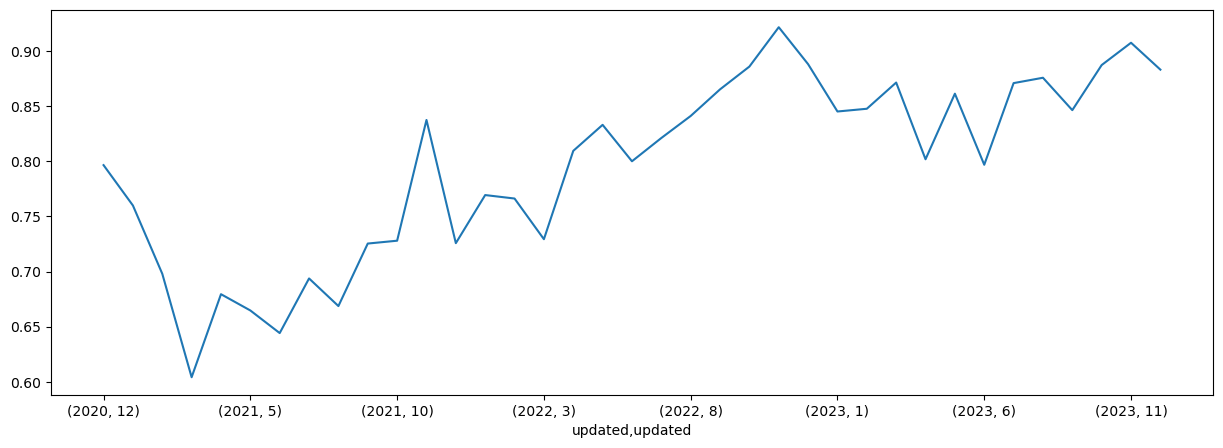

In [7]:
upvote_rate.plot(kind="line", figsize=(15, 5))

In [8]:
df["playtime_at_review"].max()

831446

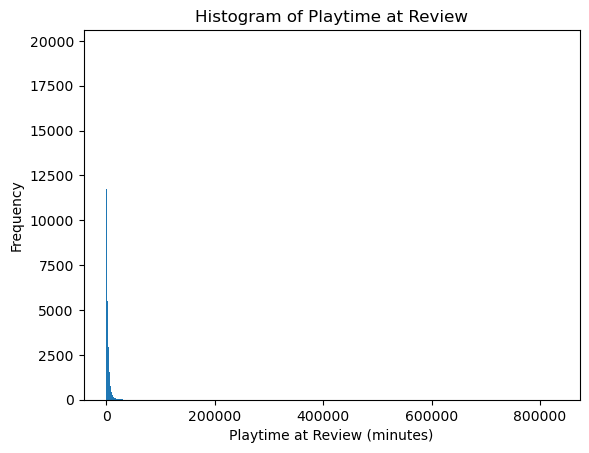

In [9]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(df['playtime_at_review'], bins=int(df['playtime_at_review'].max() / 60))

# Add labels and title
plt.xlabel('Playtime at Review (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of Playtime at Review')

# Show the histogram
plt.show()


C:\Users\Dahong Luo\AppData\Local\Temp\ipykernel_124008\2548741421.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_playtime_group = df.groupby(play_time_series)['voted_up'].mean()


<Axes: xlabel='playtime_at_review'>

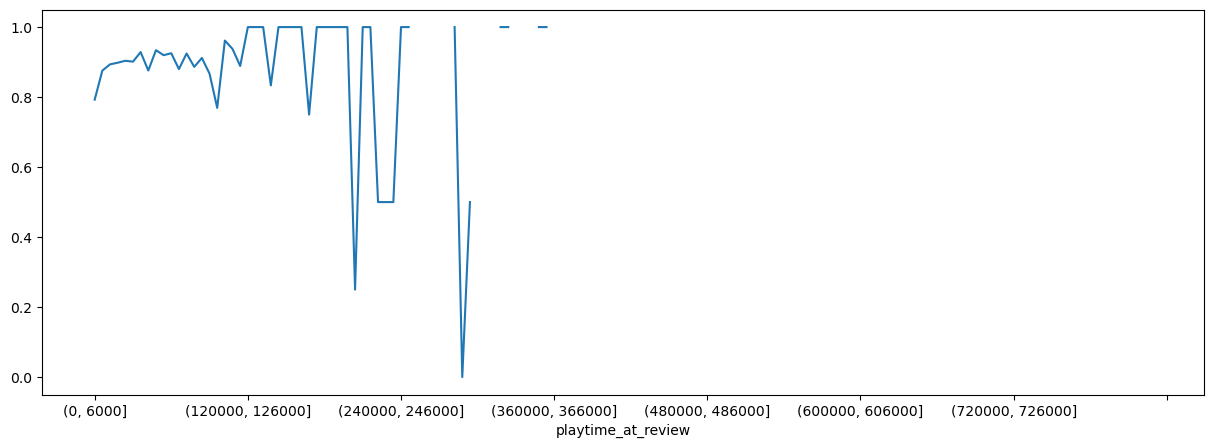

In [10]:
# Define the bin edges
bin_edges = range(0, int(df['playtime_at_review'].max()) + 6001, 6000)

# Group the data by playtime intervals
play_time_series = pd.cut(df['playtime_at_review'], bins=bin_edges)

df_playtime_group = df.groupby(play_time_series)['voted_up'].mean()
# Count the number of reviews in each playtime group
df_playtime_group.plot(kind='line', figsize=(15, 5))


*for the tests, our alpha will be 0.05*

# hypothesis 1: the longer the playtime, the more likely the review is positive


*HO:* longer playtime does not affect the voted up rate

*HA:* longer playtime affects the voted up rate

In [19]:
# performing logistic regression

import statsmodels.api as sm

#logit_model = sm.Logit(df_cpy["voted_up"], df_cpy[['intercept', 'playtime_at_review']])
# drop extreme values
df_dropped = df[df["playtime_at_review"] < 20000]

logit_model = sm.Logit(df_dropped["voted_up"], df_dropped["playtime_at_review"])
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.544010
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               voted_up   No. Observations:               605914
Model:                          Logit   Df Residuals:                   605913
Method:                           MLE   Df Model:                            0
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                -0.09967
Time:                        16:43:48   Log-Likelihood:            -3.2962e+05
converged:                       True   LL-Null:                   -2.9975e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
playtime_at_review     0.0004   1.25e-06    314.410      0.000       0.000       0.000


since the coefficient of playtime_at_review of 0.0004 is positive and is less than 0.05, we can reject the null hypothesis. Therefore, the longer the playtime, the more likely the review is positive.

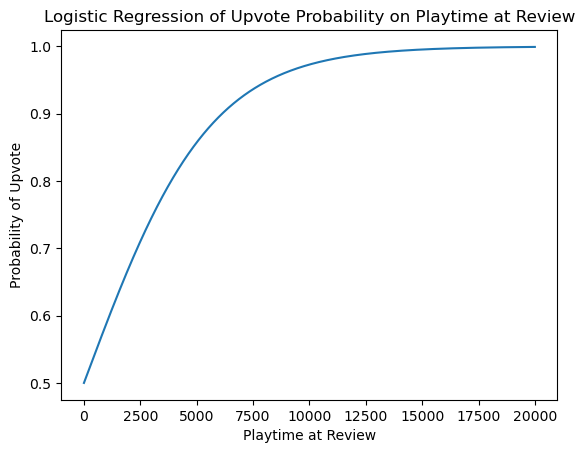

In [13]:
import numpy as np
#drop very high values because the graph will look bad otherwise because of the one guy with no life who played the game for 831446 minutes (13857 hours) and other no life people
df = df[df['playtime_at_review'] < 20000]
playtime_range = np.arange(0, df['playtime_at_review'].max() + 1, 1)
probabilities = result.predict(playtime_range)
plt.plot(playtime_range, probabilities)
plt.xlabel('Playtime at Review')
plt.ylabel('Probability of Upvote')
plt.title('Logistic Regression of Upvote Probability on Playtime at Review')
plt.show()

# hypothesis 2: Those who did not buy the game on steam are most likely trolls and will not vote up


*HO:* buying the game on steam does not affect the voted up rate

*HA:* buying the game on steam affects the voted up rate

In [14]:
from scipy.stats import chi2, chi2_contingency
contingency = pd.crosstab(df["voted_up"], df["steam_purchase"])
result = chi2_contingency(contingency)
print(result)

Chi2ContingencyResult(statistic=1900.172341977036, pvalue=0.0, dof=1, expected_freq=array([[ 12564.41594022, 106150.58405978],
       [ 51563.58405978, 435635.41594022]]))


The statistic is a really high number at 1909.9350521045753 and the p-value is 0.0, so we can reject the null hypothesis since it is less than 0.05. This is a strong evidence that online trolls literally just voted down the game without even buying it.

<Axes: xlabel='steam_purchase', ylabel='voted_up'>

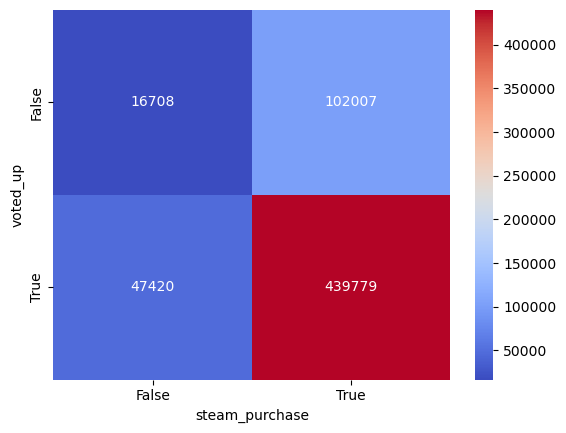

In [15]:
import seaborn as sns

sns.heatmap(contingency, annot=True, cmap='coolwarm', fmt='d')

# hypothesis 3: ascii art = more upvotes


*H0:* reviews having ascii art have the same average upvote rate as reviews without ascii art.

*HA:* reviews having ascii art have a higher average upvote rate than reviews without ascii art.

In [16]:
#alll ascii art on steam have the braille symbols which have the unicode range of 2800 to 28FF
df['has_ascii_art'] = df['review'].apply(lambda x: True if any(c for c in x if ('\u2800' <= c <= '\u28FF')) else False)

In [17]:
from scipy.stats import ttest_ind

ascii_art = df[df['has_ascii_art']]
no_ascii_art = df[~df['has_ascii_art']]
t_stat, p_val = ttest_ind(ascii_art["votes_up"] + ascii_art["votes_funny"], no_ascii_art['votes_up']+ no_ascii_art['votes_funny'], alternative='greater')

print(f"p-value: {p_val}")

p-value: 4.333161731522765e-24


Since the p-value of 4.025279811957717e-26 is less than the alpha of 0.05, we reject the null hypothesis and conclude that reviews with ascii art have a higher average upvote rate than reviews without ascii art.

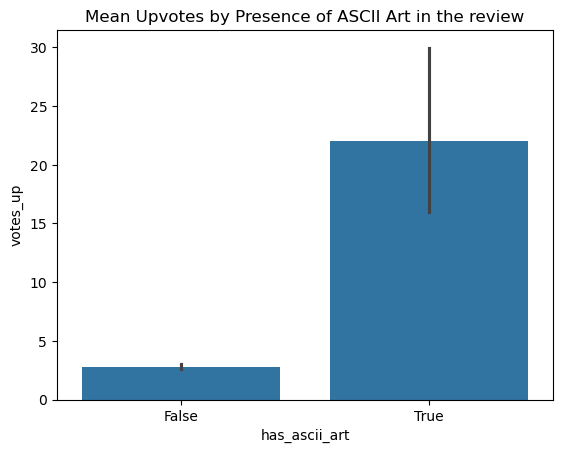

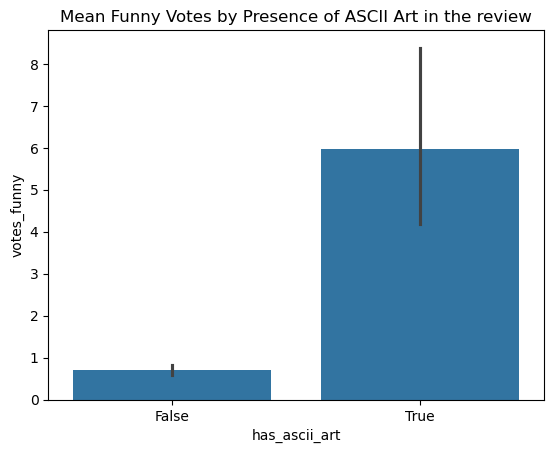

In [18]:
sns.barplot(x='has_ascii_art', y='votes_up', data=df, estimator=np.mean)
plt.title('Mean Upvotes by Presence of ASCII Art in the review')
plt.show()

sns.barplot(x='has_ascii_art', y='votes_funny', data=df, estimator=np.mean)
plt.title('Mean Funny Votes by Presence of ASCII Art in the review')
plt.show()